In [47]:
import torch as th
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import torch as th
import copy
import argparse
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
import sys
sys.path.insert(0, '../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

from guided_diffusion.script_util import (
    seed_all,
)

# from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
cfg.img_model.image_size = 256
set_ = 'valid'
# Load dataset
dataset = 'mp_valid'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
# Load dataset
if dataset in ['mp_valid', 'mp_test', 'mp_test2']:
    if dataset == 'mp_test':
        sub_f = '/MultiPIE_testset/'
    elif dataset == 'mp_test2':
        sub_f = '/MultiPIE_testset2/'
    elif dataset == 'mp_valid':
        sub_f = '/MultiPIE_validset/'
    else: raise ValueError
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/params/"
    img_ext = '.png'
    cfg.dataset.training_data = f'/MultiPIE/{sub_f}/'
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise ValueError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"
loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_=set_,
    cfg=cfg,
)

from importlib import reload
sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = True 
deca = DECA(config = deca_cfg, device='cuda', mode='shape', mask=mask)


[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml')



Loading deca params...: 100%|██████████| 10/10 [00:00<00:00, 34.24it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask


Generate the verts...:   0%|          | 0/3 [00:00<?, ?it/s]

Running :  001_03_01_051_04.png


001_03_01_051_04.png_shape_5:   0%|          | 0/3 [00:42<?, ?it/s]  

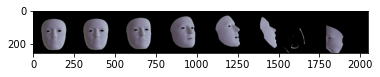

001_03_01_051_04.png_shape_5:   0%|          | 0/3 [00:48<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [51]:
def add_noise(cond, noise_at, noise_lvl):
    
    if noise_at == ['all']:
        print("[#] Apply noise to all Deca-params...")
        noise_at = ['shape', 'pose', 'exp', 'cam']
        
    for nk in noise_at:
        seed_all(47)
        # print('bf:', cond[nk])
        cond[nk] = cond[nk] + np.random.normal(0, (np.array(stat_params[nk]['sd']) * float(noise_lvl)))
        # print('af:', cond[nk])

    return cond

with open('/home/mint/guided-diffusion/experiment_scripts/statistic_test/stat_ffhq_training_deca.json', 'r') as stat_f:
    import json
    stat_params = json.load(stat_f)
    
s_e = [0, 3]
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
if s_e is None:
    img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path])
else:
    img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path][s_e[0]:s_e[1]])

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
os.makedirs(f'./output/{set_}', exist_ok=True)
import tqdm
subset_loader = iter(subset_loader)
t = tqdm.trange(len(subset_loader), desc="Generate the verts...")

out_dict = {}
noise_lvl = [0, 0.1, 0.5, 1, 1.5, 2, 3, 5]
params = ['shape', 'pose', 'exp', 'cam']
for _ in t:
    _, model_kwargs = next(subset_loader)
    each_img_name = model_kwargs['image_name'][0]
    print("Running : ", each_img_name)
    # print("Data dict-keys : ", model_kwargs.keys())
    text = ""
    out_dict[each_img_name] = {}
    for p in params:
        all_render = []
        out_dict[each_img_name][p] = {}
        for nlvl in noise_lvl:
            out_dict[each_img_name][p][f'nlvl={nlvl}'] = {
                'landmarks2d':{}, 
                'landmarks3d':{},
                'verts':{},
                'trans_verts':{}, 
                'landmarks2d_orig':{}, 
                'landmarks3d_orig':{}, 
                'trans_verts_orig':{}
            }
            text = f'{each_img_name}_{p}_{nlvl}'
            s_ren_t = time.time()
            
            if nlvl != 0:
                model_kwargs = add_noise(cond=copy.deepcopy(model_kwargs), noise_at=['pose'], noise_lvl=nlvl)
            rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, 
                                                                    idx=0, n=1, 
                                                                    useTex=True, extractTex=True, 
                                                                    deca_mode='', use_detail=True, mask=mask, repeat=False, 
                                                                    deca_obj=deca)
            # text += "[#] Elapsed time ({}) => render : {:.3f}".format(each_img_name, time.time() - s_ren_t)
            # print(orig_visdict.keys())
            for k in out_dict[each_img_name][p][f'nlvl={nlvl}'].keys():
                out_dict[each_img_name][p][f'nlvl={nlvl}'][k] = orig_visdict[k][0].cpu().numpy()
            
            all_render.append(rendered_image[0].cpu().numpy().transpose(1, 2, 0))
            # print(rendered_image.shape)
            plt.show()
            t.set_description(text)
            t.refresh()
            
        all_render = np.concatenate(all_render, axis=1)
        plt.imshow(all_render)
        plt.savefig(f'./output/valid/render/{each_img_name}_{p}.png')
        plt.show()
    np.save(file=f'./output/valid/verts_valid.npy', arr=out_dict)


In [49]:

import plotly.graph_objects as go
fig = go.Figure()

original_verts = out_dict['001_03_01_051_04.png']['pose'][f'nlvl=0']['verts'][mask['v_mask'], :]
mse_dist = []
rmse_dist = []
for nlvl in noise_lvl:
    plot_verts = out_dict['001_03_01_051_04.png']['pose'][f'nlvl={nlvl}']['verts'][mask['v_mask'], :]
    fig.add_trace(go.Scatter3d(x=plot_verts[:, 0], y=plot_verts[:, 1], z=plot_verts[:, 2],
                                    mode='markers', marker_size=1.2, name=f'nlvl={nlvl}'))
    l2 = (original_verts-plot_verts)**2
    mse = np.mean(l2)
    rmse = np.sqrt(np.mean(np.sum(l2, axis=1, keepdims=True)))
    mse_dist.append(mse)
    rmse_dist.append(rmse)
fig.show()
print(mse_dist)
print(rmse_dist)

[0.0, 8.34315e-06, 0.00029882268, 0.0020631345, 0.00705168, 0.015259336, 0.021379696, 0.0061016087]
[0.0, 0.0050029443, 0.029941076, 0.07867276, 0.14544772, 0.21395795, 0.25325695, 0.13529533]
